In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline


# Blind source separation using NMF

Toy example using two sinusoidal signals


In [3]:
print(__doc__)

import os as os
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
from sigtools.sigtools import *
from scipy.signal import stft, istft, spectrogram, chirp, butter, lfilter, freqz
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from numpy import linalg


Automatically created module for IPython interactive environment


In [4]:
plt.rcParams['figure.figsize'] = (12.0, 9.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rc('text', usetex=True)
plt.rc('font', family='times')
plt.rcParams.update({'font.size': 26})

In [5]:
figPath = './figs-01-31/'
fs = 32.768e6
nfft = 19
nperseg = 19
beta_loss = 'kullback-leibler'
save_fig = True
exp_name = 'psk'

In [6]:
def plotSpectrogram(f, t, Sxx, vmin=None, vmax=None, save_fig=False, fig_path=None, figName=None):
    specdB = 10*np.log10(np.abs(Sxx))    
    cmap = plt.get_cmap('jet')
    
    if vmin==None and vmax==None:
        vmin = np.min(specdB)
        vmax = np.max(specdB)       
        
    plt.pcolormesh(t*1e3, f/1e6, specdB, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.ylabel('Frequency [MHz]')
    plt.xlabel('Time [ms]')
    plt.colorbar().ax.set_ylabel('[dB]')
    plt.tight_layout()
    if save_fig:
        if not os.path.exists(fig_path):
            os.makedirs(fig_path)
        figName = ''.join([figName, '.eps'])
        plt.savefig(os.path.join(fig_path,figName), dpi=100, format='eps')
    plt.show()

In [7]:
def saveFig(fig, fig_path, fig_name, save_fig=False):
    if save_fig:
        if not os.path.exists(fig_path):
            os.makedirs(fig_path)
        fig_name = ''.join([fig_name, '.eps'])
        fig.savefig(os.path.join(fig_path, fig_name), dpi=100, format='eps')

In [8]:
def pskmod(y, order=4, init_phase=0):
    if order!=4:
        raise ValueError('PSK order must be 4')
    if np.max(y) > (order-1) or np.min(y) < 0:
        raise ValueError('Invalid input vector')
    proof = [1, 1j, -1, -1j]
    mod_vector = []
    [mod_vector.append(proof[i]) for i in y]
    mod_vector = np.asarray(mod_vector)*np.exp(1j*init_phase)
    return mod_vector
    

In [9]:
def mean_window(y, window_length, hop_size=1):
    aux = (y.shape[0] - window_length)//hop_size
    if aux is not int(aux):
         raise ValueError('Window size and hop size are incompatible')
            
    number_of_windows = aux + 1
    window = []
    for i in range(number_of_windows):
        window.append(np.mean(y[i:i+window_length:hop_size]))
    return np.asarray(window)

# Generate and mix signals

/home/felipe/miniconda3/envs/python3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['times'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


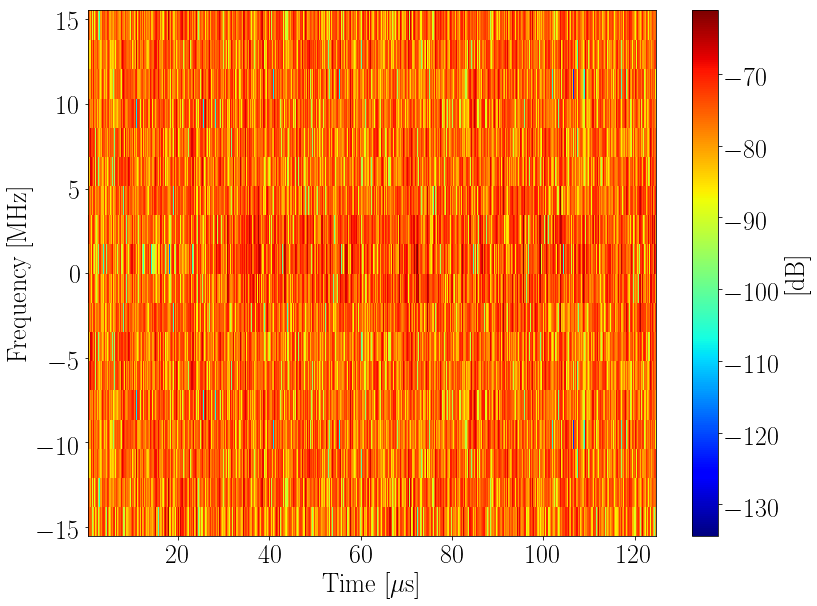

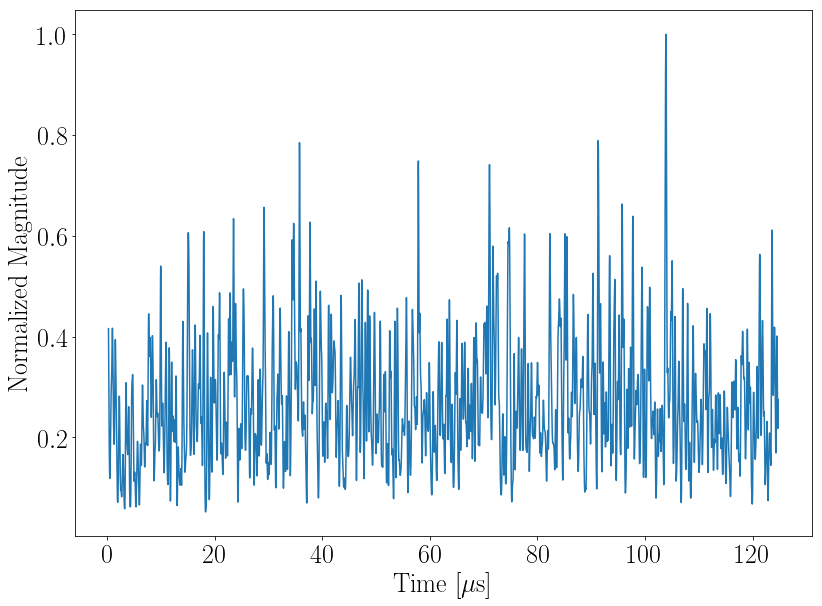

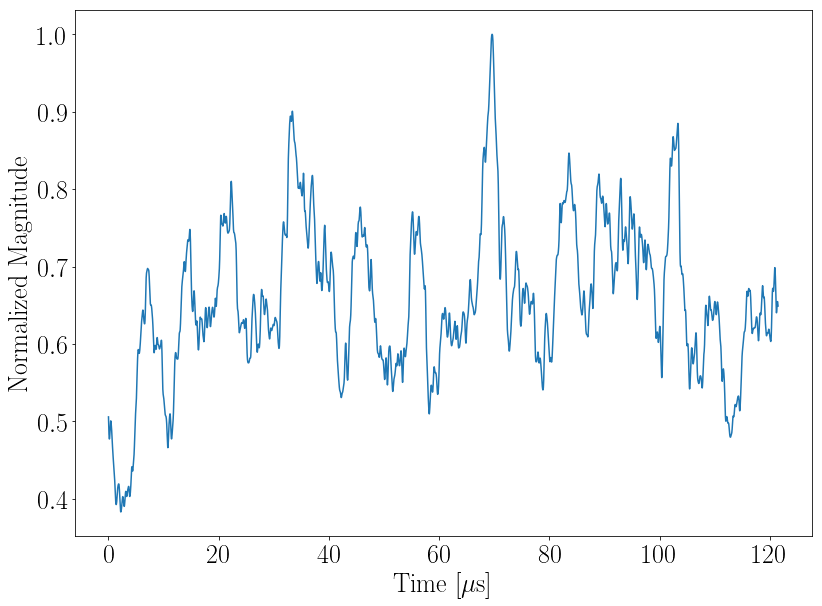

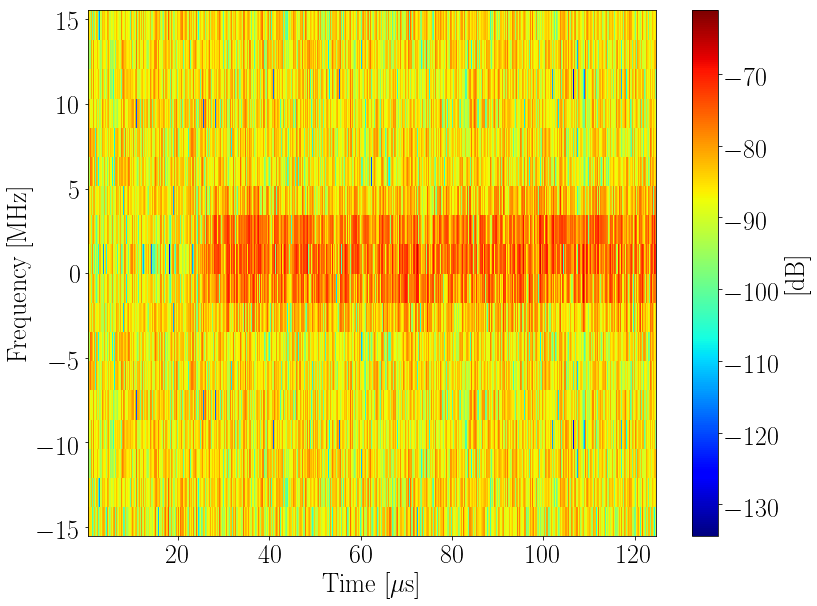

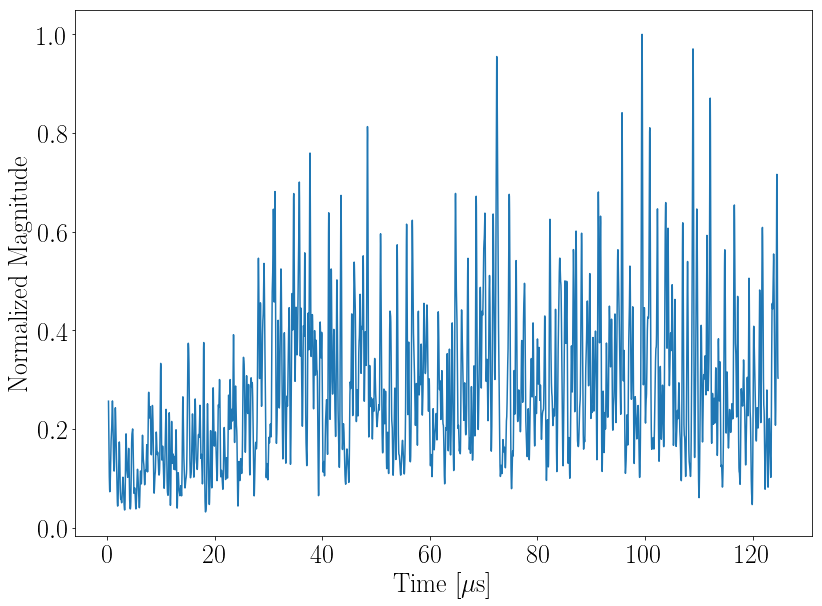

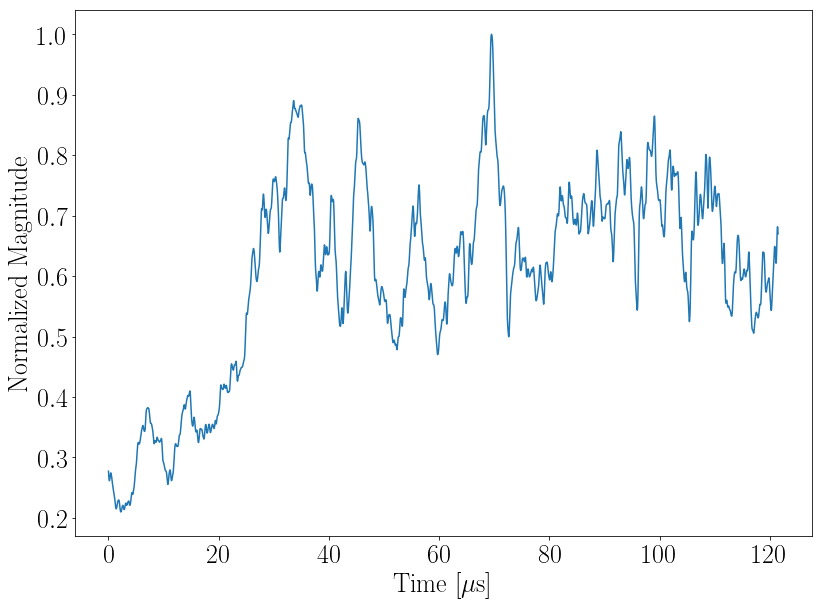

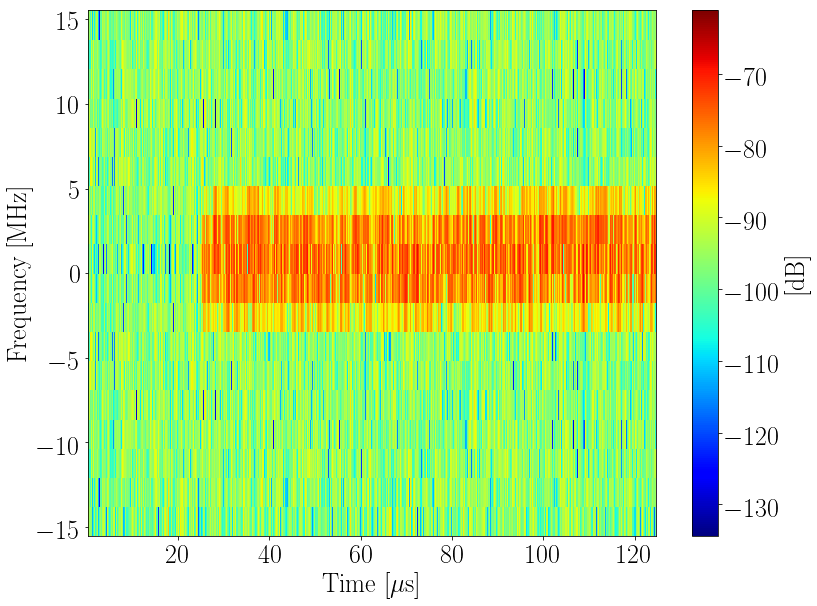

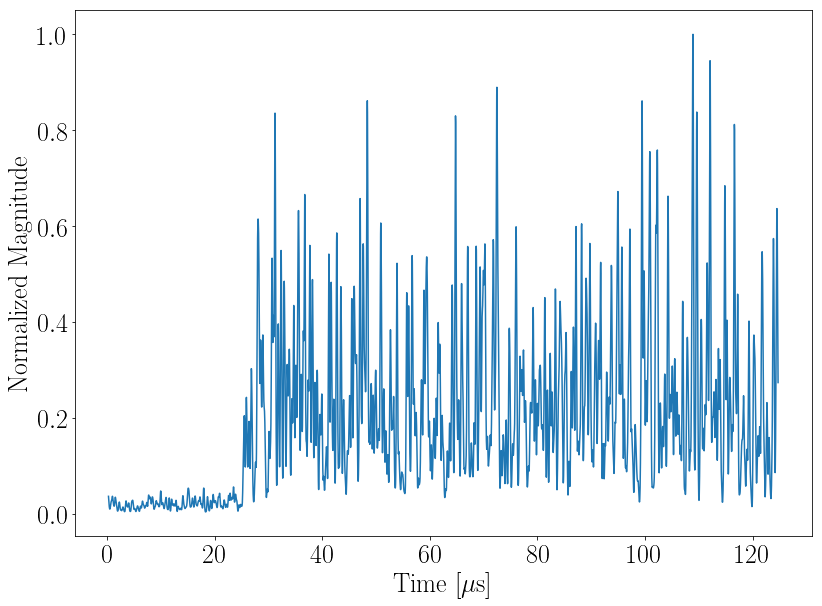

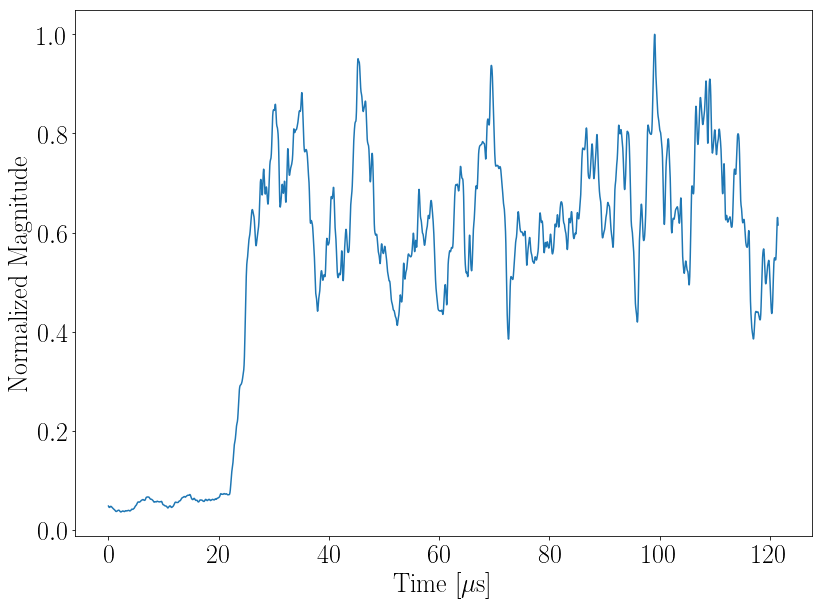

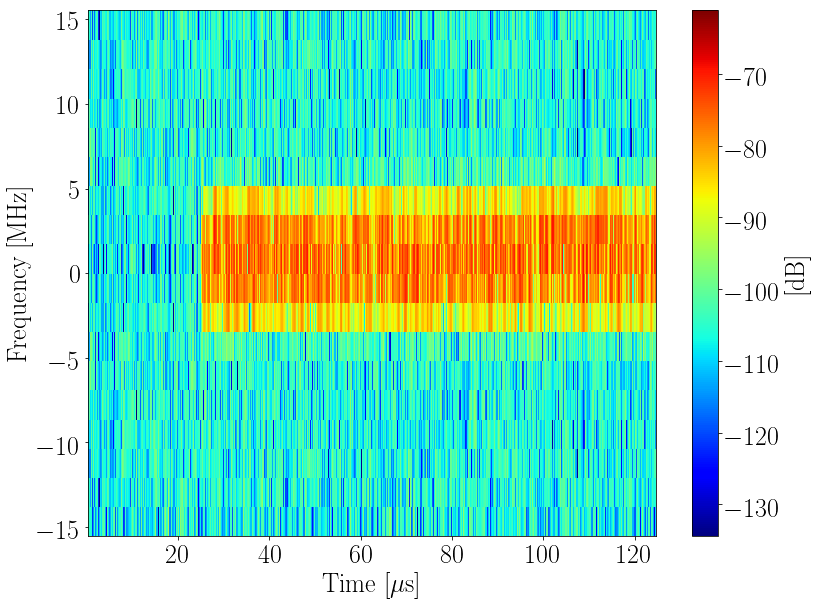

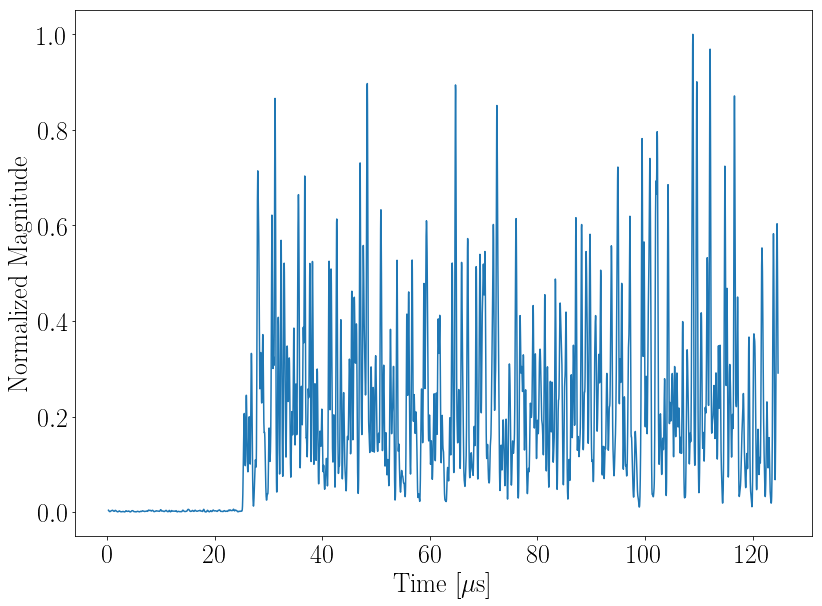

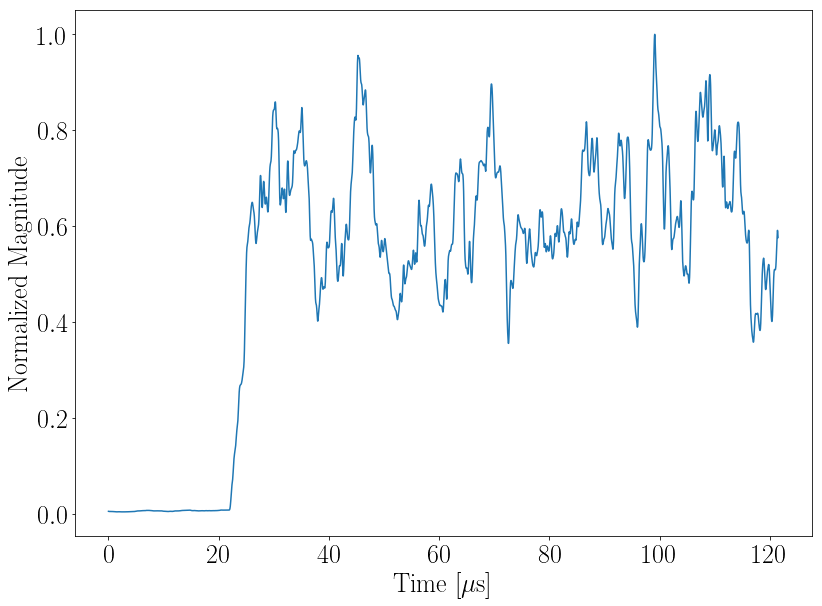

In [10]:
JNRVector = [-10, 0, 10, 20]
JNR = []
[JNR.append(db2pow(i)) for i in JNRVector]

secondsOfData = 100e-6
numberOfSamples = int(secondsOfData*fs)
totalSamples = 4096

cutoff = 2e6

signal1 = pskmod(np.random.randint(0, high=4, size=numberOfSamples))
signal1 = butter_lowpass_filter(signal1, cutoff, fs, order=6)
pow1 = pow_eval(signal1)
signal1 = np.concatenate((np.zeros(totalSamples - signal1.shape[0]), signal1))
noise = np.random.randn(len(signal1))
powNoise = pow_eval(noise)
window_length = int(3e-6*fs)

for j, i in enumerate(JNR):
    powAux = pow1/i
    noise2 = noise*np.sqrt(powAux/powNoise)
    data = signal1+noise2
        
    cmap = plt.get_cmap('jet')
    Pxx, freqs, bins, _ = plt.specgram(data, Fs=fs, NFFT=nfft, noverlap=nfft-1, cmap=cmap,
                                          detrend='none', sides='twosided')
    plt.close()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    inputNMF = np.abs(Pxx)
    inputNMF = np.where(inputNMF==0, 1e-12, inputNMF)
    specdB = 10*np.log10(inputNMF)
        
    if j == 0:
        vmin = np.min(specdB)
        vmax = np.max(specdB)
            
    v = ax.pcolormesh(bins*1e6, freqs/1e6, specdB, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_ylabel('Frequency [MHz]')
    ax.set_xlabel('Time [$\mu$s]')
    fig.colorbar(v).ax.set_ylabel('[dB]')
    plt.tight_layout()
    saveFig(fig, figPath, ''.join(['spec_input', exp_name, 'JNR_', str(JNRVector[j])]), save_fig=save_fig)
    plt.show()

    model = NMF(init='nndsvda', max_iter=10000, verbose=0, random_state=1, tol=1e-16, 
                  beta_loss=beta_loss, n_components=1, solver='mu')
    W = model.fit_transform(inputNMF)
    H = model.components_

    for l in range(H.shape[0]):
        HNorm = H[l,:]/np.max(H[l,:])
        H2 = mean_window(HNorm, window_length)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(bins*1e6, HNorm)
        ax.set_xlabel('Time [$\mu$s]')
        ax.set_ylabel('Normalized Magnitude')
        fig.tight_layout()
        saveFig(fig, figPath, ''.join(['act', exp_name, 'JNR_', str(JNRVector[j])]), save_fig=save_fig)
        plt.show()

        fig = plt.figure()
        ax = fig.add_subplot(111)
        taux = np.linspace(0, H2.shape[0]/fs, H2.shape[0])*1e6
        ax.plot(taux, H2/np.max(H2))
        ax.set_xlabel('Time [$\mu$s]')
        ax.set_ylabel('Normalized Magnitude')
        fig.tight_layout()
        saveFig(fig, figPath, ''.join(['act', exp_name, 'JNR_', str(JNRVector[j]),
                                       '_window']), save_fig=save_fig)
        plt.show()

# Saving log file

In [11]:
import json

In [12]:
log_path = './log/'
if not os.path.exists(log_path):
    os.makedirs(log_path)
params = model.get_params()
params['nfft'] = nfft
params['nperseg'] = nperseg
params = json.dumps(params)
if save_fig:
    with open(''.join([log_path, exp_name, beta_loss, '.p']), 'w') as file:
         file.write(params)